In [58]:
using Plots
using FFTW
using DSP
using StatsPlots
using StatsBase
using Statistics

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Data Importing

In [59]:
include("../helper/importing.jl")
lfp_data = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 101/")
o2_data = import_o2("Exp 2/R7/o2 r7.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [328293.0, 450314.0, 495567.0, 535427.0, 627203.0, 731830.0, …
  "sync"       => [30452.0, 40944.0, 51395.0, 61876.0, 72372.0, 82849.0, 93294.…
  "data"       => [-269.721, -269.721, -269.721, -269.721, -269.721, -269.721, …
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.5976f…

## Extracting Envelope of LFP Data

In [60]:
# Compute the Fourier Transform
sampling_rate = 1000
channel = 1
F = fft(lfp_data["data"][channel,:])
freqs = fftfreq(length(lfp_data["data"][channel,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end

# Apply the Band-Pass Butterworth filter
band = [1, 45]
band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
end

banded_lfp_data = real(ifft(band_pass_F))
lfp_envelope = abs.(hilbert(banded_lfp_data))

1602560-element Vector{Float32}:
 0.109965876
 0.119730115
 0.13008651
 0.14100732
 0.15243986
 0.16430683
 0.17650767
 0.18891968
 0.20140402
 0.21380952
 ⋮
 0.04566127
 0.051053923
 0.056842927
 0.06302867
 0.06962733
 0.076666184
 0.08418154
 0.09221326
 0.10079832

## Band-Pass Filtering O2 Data

In [61]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2_data["data"])
freqs = fftfreq(length(o2_data["data"]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2_data = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.49391225
  0.5759197
  0.65408814
  0.7261298
  0.7901367
  0.8446827
  0.8888846
  0.92242074
  0.94550717
  0.958839
  ⋮
 -0.040919203
 -0.017872652
  0.015638491
  0.059826728
  0.11436706
  0.17837344
  0.25041714
  0.32858807
  0.41059664

## Visualising Laser Stimulation Effect

### Single Event Effect

This section will plot the effect after a single laser event has occurred

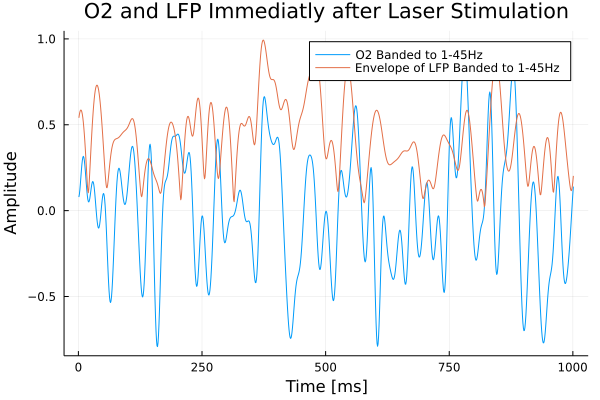

In [62]:
laser_flag = 1

o2_start = findall(x->x==o2_data["laser"][laser_flag], o2_data["timestamps"])[1]
lfp_start = findall(x->x==lfp_data["laser"]["on"][laser_flag], lfp_data["timestamps"])[1]
increment = 1000

plot(banded_o2_data[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_envelope[lfp_start:lfp_start+increment], label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [67]:
cor(banded_o2_data[o2_start:o2_start+increment], lfp_envelope[lfp_start:lfp_start+increment])

0.22563057f0

### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [63]:
o2_starts = findall(x->x in o2_data["laser"][laser_flag], o2_data["timestamps"])
lfp_starts = findall(x->x in lfp_data["laser"]["on"][laser_flag], lfp_data["timestamps"])
increment = 1000

diffs = o2_data["laser"][1:10] - lfp_data["laser"]["on"][1:10]

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += standardize(ZScoreTransform, banded_o2_data[i:i+increment])
end

for i in lfp_starts
    lfp_subset_mean += standardize(ZScoreTransform, lfp_envelope[i:i+increment])
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)

1001-element Vector{Float64}:
  0.6094281077384949
  0.7036678194999695
  0.7732076048851013
  0.816368043422699
  0.8318666815757751
  0.8188402652740479
  0.7768454551696777
  0.7058706283569336
  0.6063185930252075
  0.47900256514549255
  ⋮
 -1.1934123039245605
 -1.3019897937774658
 -1.3921372890472412
 -1.4508682489395142
 -1.462618112564087
 -1.4188727140426636
 -1.325250267982483
 -1.195433497428894
 -1.0425204038619995

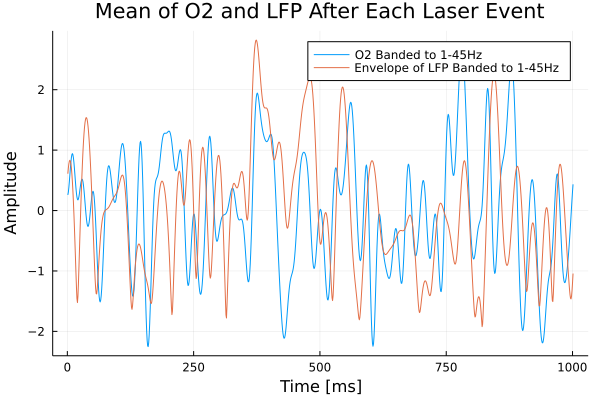

In [64]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [66]:
cor(o2_subset_mean, lfp_subset_mean)

0.22563058869277836